In [3]:
import pandas as pd
from datasets import Dataset
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc
from sklearn.metrics import precision_recall_curve
import torch
import pickle
import matplotlib.pyplot as plt
import numpy as np


In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
df_model = pd.read_csv('df_jokes_final_category.csv')

In [5]:
df_model.head()

,merged_text,final_category
0,I am soooo glad I'm not circumcised! My corona...,adult
1,Did you know Google now has a platform for rec...,pun
2,What is the difference between my wife and my ...,dark humor
3,What did the French man say to the attractive ...,pun
4,"Yo Mama Yo momma's so fat, that when she went ...",pun


In [6]:
# Encode target labels
label_encoder = LabelEncoder()
df_model['encoded_category'] = label_encoder.fit_transform(df_model['final_category'])

In [7]:
train_texts, test_texts, train_labels, test_labels = train_test_split(
    df_model['merged_text'],
    df_model['encoded_category'],
    test_size=0.2,
    random_state=42,
    stratify=df_model['encoded_category']
)

In [8]:
# Convert to Hugging Face Dataset format
train_data = pd.DataFrame({'text': train_texts, 'label': train_labels})
test_data = pd.DataFrame({'text': test_texts, 'label': test_labels})

hf_train = Dataset.from_pandas(train_data)
hf_test = Dataset.from_pandas(test_data)

In [9]:
model_name = "bert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=len(label_encoder.classes_)).to(device)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [10]:
# Tokenize data
def tokenize_function(examples):
    return tokenizer(examples['text'], truncation=True, padding='max_length', max_length=128)

In [11]:
hf_train = hf_train.map(tokenize_function, batched=True)
hf_test = hf_test.map(tokenize_function, batched=True)
hf_train.set_format(type='torch', columns=['input_ids', 'attention_mask', 'label'])
hf_test.set_format(type='torch', columns=['input_ids', 'attention_mask', 'label'])

Map:   0%|          | 0/44751 [00:00<?, ? examples/s]

Map:   0%|          | 0/11188 [00:00<?, ? examples/s]

In [12]:
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    acc = accuracy_score(labels, preds)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average="weighted")
    return {
        "accuracy": acc,
        "precision": precision,
        "recall": recall,
        "f1": f1
    }

In [13]:
# Define trainer
training_args = TrainingArguments(
    output_dir="./results",
    eval_strategy="epoch",
    save_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=3,
    weight_decay=0.01,
    logging_dir="./logs",
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    report_to="none"  # Disable W&B logging
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=hf_train,
    eval_dataset=hf_test,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

<ipython-input-13-6864b7999c28>:17: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [1]:
trainer.train()

# Evaluate the model
eval_results = trainer.evaluate()
print("Evaluation Results:", eval_results)


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 24.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 11.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 15.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 10.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 17.2 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/44751 [00:00<?, ? examples/s]

Map:   0%|          | 0/11188 [00:00<?, ? examples/s]

<ipython-input-1-a908270472cc>:84: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.665700,0.656885,0.728638,0.717943,0.728638,0.713832
2,0.507800,0.688079,0.732481,0.727810,0.732481,0.724580
3,0.327300,0.824165,0.727833,0.725975,0.727833,0.725520


Evaluation Results: {'eval_loss': 0.6880791187286377, 'eval_accuracy': 0.732481229889167, 'eval_precision': 0.7278098913382712, 'eval_recall': 0.732481229889167, 'eval_f1': 0.7245797466711474, 'eval_runtime': 82.1572, 'eval_samples_per_second': 136.178, 'eval_steps_per_second': 8.52, 'epoch': 3.0}


In [2]:
# Save the model and tokenizer
with open("text_classifier_model.pkl", "wb") as f:
    pickle.dump(model, f)

with open("tokenizer.pkl", "wb") as f:
    pickle.dump(tokenizer, f)

print("Model and tokenizer saved as .pkl files.")


Model and tokenizer saved as .pkl files.


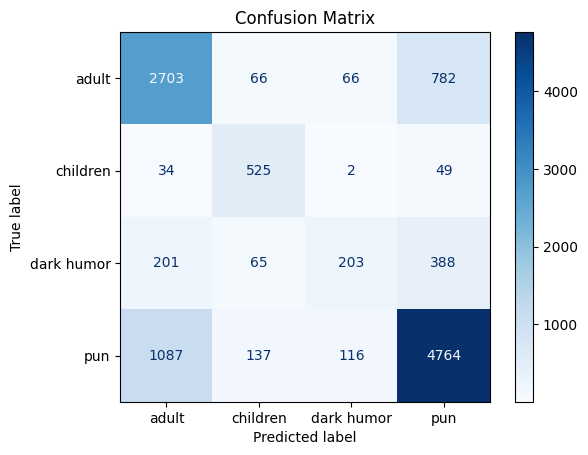

AttributeError: 'Tensor' object has no attribute 'astype'

In [9]:
predictions = trainer.predict(hf_test).predictions.argmax(axis=1)
true_labels = hf_test['label']

conf_matrix = confusion_matrix(true_labels, predictions, labels=range(len(label_encoder.classes_)))
disp = ConfusionMatrixDisplay(conf_matrix, display_labels=label_encoder.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()




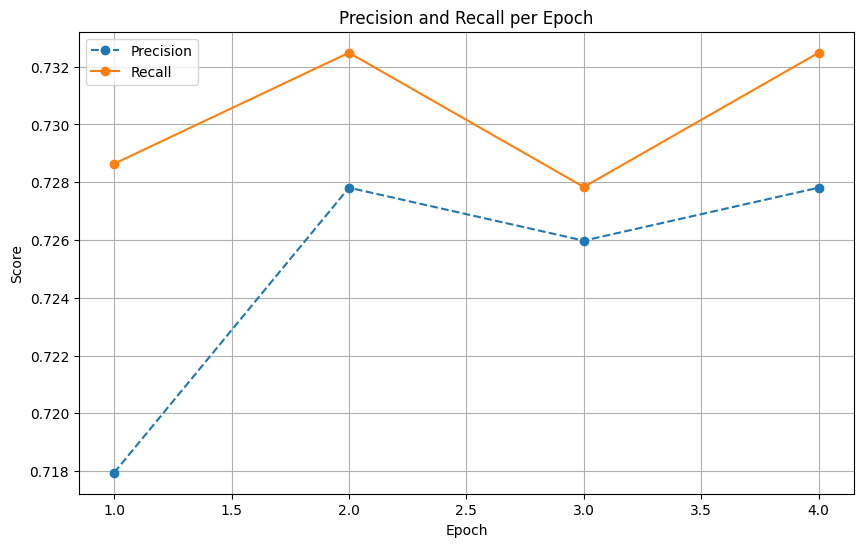

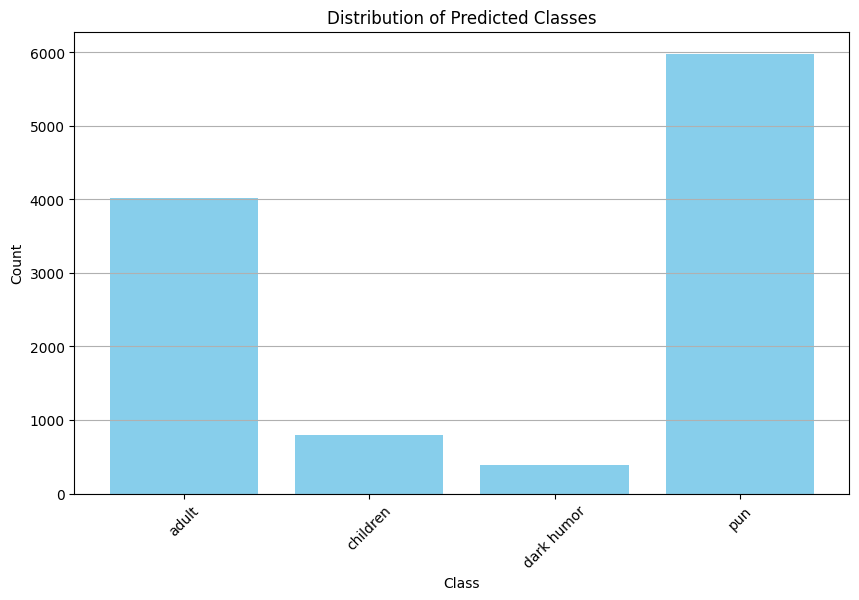

In [14]:
# Precision and Recall per Epoch
eval_precision = [log["eval_precision"] for log in trainer.state.log_history if "eval_precision" in log]
eval_recall = [log["eval_recall"] for log in trainer.state.log_history if "eval_recall" in log]
epochs = range(1, len(eval_precision) + 1)

plt.figure(figsize=(10, 6))
plt.plot(epochs, eval_precision, label="Precision", marker="o", linestyle="--")
plt.plot(epochs, eval_recall, label="Recall", marker="o", linestyle="-")
plt.title("Precision and Recall per Epoch")
plt.xlabel("Epoch")
plt.ylabel("Score")
plt.legend()
plt.grid(True)
plt.show()

# Distribution of Predicted Classes
predicted_labels = predictions
predicted_class_counts = np.bincount(predicted_labels, minlength=len(label_encoder.classes_))

plt.figure(figsize=(10, 6))
plt.bar(label_encoder.classes_, predicted_class_counts, color="skyblue")
plt.title("Distribution of Predicted Classes")
plt.xlabel("Class")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.grid(axis="y")
plt.show()





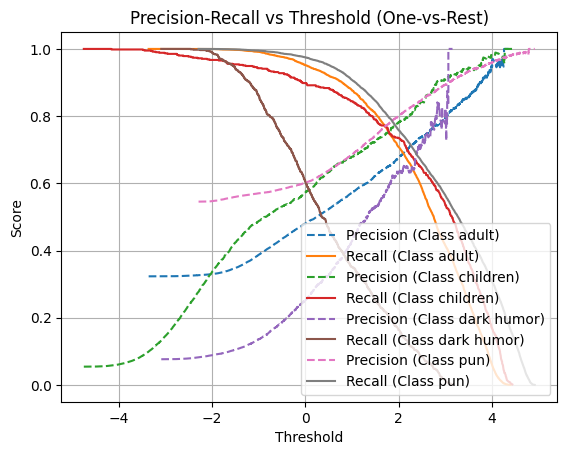

In [17]:
true_labels = true_labels.cpu().numpy() if hasattr(true_labels, "cpu") else true_labels.numpy()
probabilities = trainer.predict(hf_test).predictions

for i, class_label in enumerate(label_encoder.classes_):
    true_binary = (true_labels == i).astype(int)
    precision, recall, thresholds = precision_recall_curve(true_binary, probabilities[:, i])

    plt.plot(thresholds, precision[:-1], label=f"Precision (Class {class_label})", linestyle="--")
    plt.plot(thresholds, recall[:-1], label=f"Recall (Class {class_label})", linestyle="-")


plt.title("Precision-Recall vs Threshold (One-vs-Rest)")
plt.xlabel("Threshold")
plt.ylabel("Score")
plt.legend(loc="best")
plt.grid(True)
plt.show()


### **Model Workflow and Insights**

#### **Workflow**
1. **Dataset Preparation**:
   - The dataset was preprocessed to include target labels encoded using
     LabelEncoder.
   - A stratified train-test split was performed, ensuring balanced distributions across training and testing datasets.

2. **Data Tokenization**:
   - The `merged_text` column was tokenized using the BERT tokenizer, converting texts into `input_ids` and `attention_mask` suitable for model input.

3. **Model Initialization**:
   - A pre-trained BERT base model was loaded for sequence classification, adjusted for the number of output categories corresponding to the joke classifications.

4. **Training**:
   - The model was trained using the Hugging Face Trainer API with the following hyperparameters:
     - Learning Rate: `2e-5`
     - Batch Size: `16`
     - Number of Epochs: `3`
   - GPU acceleration was utilized to optimize computation.

5. **Evaluation**:
   - Model performance was evaluated using metrics such as **accuracy**, **precision**, **recall**, and **F1 score**.
   - Training and validation losses were tracked across epochs for insight into the model's generalization capabilities.

6. **Visualization**:
   - A confusion matrix, precision-recall curves, predicted class distribution, and loss trends were generated for in-depth analysis of model behavior.


####         **Insights from the Training Table**
| **Epoch** | **Training Loss** | **Validation Loss** | **Accuracy** | **Precision** | **Recall** | **F1** |
|-----------|--------------------|----------------------|--------------|---------------|------------|--------|
| 1         | 0.665700          | 0.656885            | 0.728638     | 0.717943      | 0.728638   | 0.713832 |
| 2         | 0.507800          | 0.688079            | 0.732481     | 0.727810      | 0.732481   | 0.724580 |
| 3         | 0.327300          | 0.824165            | 0.727833     | 0.725975      | 0.727833   | 0.725520 |

1. **Accuracy and Metrics**:
   - The model achieves its **highest accuracy** of **73.25%** during the second epoch, with strong precision and recall scores.
   - The F1 score remains stable, reflecting a balanced trade-off between precision and recall.

2. **Loss Trends**:
   - **Training Loss** consistently decreases across epochs, showcasing effective learning.
   - **Validation Loss** increases significantly during the third epoch, suggesting **overfitting**, as the model may have started memorizing the training data.

3. **Key Observations**:
   - The second epoch strikes the best balance between training and validation losses, achieving peak accuracy and generalization performance.
   - Additional regularization techniques or early stopping could help mitigate overfitting in the later epochs.



#### **Insights from Visualizations**
1. **Precision and Recall per Epoch**:
   - Recall improves steadily across epochs, showing the model's increasing ability to capture relevant instances.
   - Precision remains stable, highlighting the model's consistency in accurate classifications.

2. **Distribution of Predicted Classes**:
   - The model predicts more instances for the `pun` and `adult` categories compared to `dark humor` and `children`.

3. **Precision-Recall vs Threshold**:
   - The trade-off between precision and recall is evident across thresholds for each class.
   - For `pun`, recall is high at lower thresholds, while precision is higher at stricter thresholds, illustrating how thresholds influence performance.



### **Conclusion**
The model demonstrates strong classification capabilities, achieving **73.25% accuracy** and stable precision and recall.